# Feature Engineering and Dataset Balancing for Emotion Recognition

This notebook implements feature engineering and dataset balancing techniques to improve the emotion recognition model performance by addressing class imbalance issues.

## Problem Statement
The EmoSet dataset has significant class imbalance:
- **happy**: 25.24% (overrepresented)
- **surprise**: 11.29% (underrepresented)
- Other emotions range from 14-17%

## Solution Approach
1. Analyze current dataset distribution
2. Implement dataset balancing techniques
3. Create balanced train/validation/test splits
4. Save processed datasets for model training

In [32]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.utils import resample
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Feature Engineering Environment Setup Complete")

Feature Engineering Environment Setup Complete


In [33]:
# Define project paths
PROJECT_ROOT = Path('../')
CSV_TRAIN = PROJECT_ROOT / 'data/processed/EmoSet_splits/train.csv'
CSV_VAL = PROJECT_ROOT / 'data/processed/EmoSet_splits/val.csv'
CSV_TEST = PROJECT_ROOT / 'data/processed/EmoSet_splits/test.csv'
LABEL_MAP_PATH = PROJECT_ROOT / 'data/processed/EmoSet_splits/label_map.json'
STATS_PATH = PROJECT_ROOT / 'data/processed/EmoSet_splits/stats.json'
DATA_DIR = PROJECT_ROOT / 'data/raw/EmoSet'

# Output paths for balanced datasets
BALANCED_TRAIN_CSV = PROJECT_ROOT / 'data/processed/EmoSet_splits/train_balanced.csv'
BALANCED_VAL_CSV = PROJECT_ROOT / 'data/processed/EmoSet_splits/val_balanced.csv'
BALANCED_TEST_CSV = PROJECT_ROOT / 'data/processed/EmoSet_splits/test_balanced.csv'
BALANCED_STATS_PATH = PROJECT_ROOT / 'data/processed/EmoSet_splits/stats_balanced.json'

print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_DIR}")
print("\nInput files:")
for path in [CSV_TRAIN, CSV_VAL, CSV_TEST, LABEL_MAP_PATH]:
    print(f"  {path.name}: {'✓' if path.exists() else '✗'}")

Project root: ..
Data directory: ../data/raw/EmoSet

Input files:
  train.csv: ✓
  val.csv: ✓
  test.csv: ✓
  label_map.json: ✓


In [34]:
# Load existing datasets
print("Loading current datasets...")
train_df = pd.read_csv(CSV_TRAIN)
val_df = pd.read_csv(CSV_VAL)
test_df = pd.read_csv(CSV_TEST)

# Load label mapping
with open(LABEL_MAP_PATH, 'r') as f:
    label_map = json.load(f)

print(f"Train set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")
print(f"\nEmotion classes: {list(label_map.keys())}")
print(f"Number of classes: {len(label_map)}")

Loading current datasets...
Train set: 27090 samples
Validation set: 5418 samples
Test set: 1350 samples

Emotion classes: ['angry', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
Number of classes: 6


In [35]:
def analyze_class_distribution(df, split_name):
    """Analyze and visualize class distribution"""
    class_counts = df['label'].value_counts().sort_index()
    class_percentages = (class_counts / len(df) * 100).round(2)
    
    print(f"\n{split_name.upper()} SET CLASS DISTRIBUTION:")
    print("=" * 50)
    for emotion, count in class_counts.items():
        pct = class_percentages[emotion]
        status = "OVERREPRESENTED" if pct > 20 else "UNDERREPRESENTED" if pct < 14 else "BALANCED"
        print(f"{emotion:10s}: {count:5d} ({pct:5.2f}%) - {status}")
    
    print(f"\nTotal samples: {len(df)}")
    print(f"Mean per class: {len(df) / len(class_counts):.1f}")
    print(f"Std deviation: {class_counts.std():.1f}")
    print(f"Balance ratio (min/max): {class_counts.min() / class_counts.max():.3f}")
    
    return class_counts, class_percentages

# Analyze current distributions
train_counts, train_pct = analyze_class_distribution(train_df, "train")
val_counts, val_pct = analyze_class_distribution(val_df, "validation")
test_counts, test_pct = analyze_class_distribution(test_df, "test")


TRAIN SET CLASS DISTRIBUTION:
angry     :  4515 (16.67%) - BALANCED
fearful   :  4515 (16.67%) - BALANCED
happy     :  4515 (16.67%) - BALANCED
neutral   :  4515 (16.67%) - BALANCED
sad       :  4515 (16.67%) - BALANCED
surprised :  4515 (16.67%) - BALANCED

Total samples: 27090
Mean per class: 4515.0
Std deviation: 0.0
Balance ratio (min/max): 1.000

VALIDATION SET CLASS DISTRIBUTION:
angry     :   903 (16.67%) - BALANCED
fearful   :   903 (16.67%) - BALANCED
happy     :   903 (16.67%) - BALANCED
neutral   :   903 (16.67%) - BALANCED
sad       :   903 (16.67%) - BALANCED
surprised :   903 (16.67%) - BALANCED

Total samples: 5418
Mean per class: 903.0
Std deviation: 0.0
Balance ratio (min/max): 1.000

TEST SET CLASS DISTRIBUTION:
angry     :   225 (16.67%) - BALANCED
fearful   :   225 (16.67%) - BALANCED
happy     :   225 (16.67%) - BALANCED
neutral   :   225 (16.67%) - BALANCED
sad       :   225 (16.67%) - BALANCED
surprised :   225 (16.67%) - BALANCED

Total samples: 1350
Mean per c

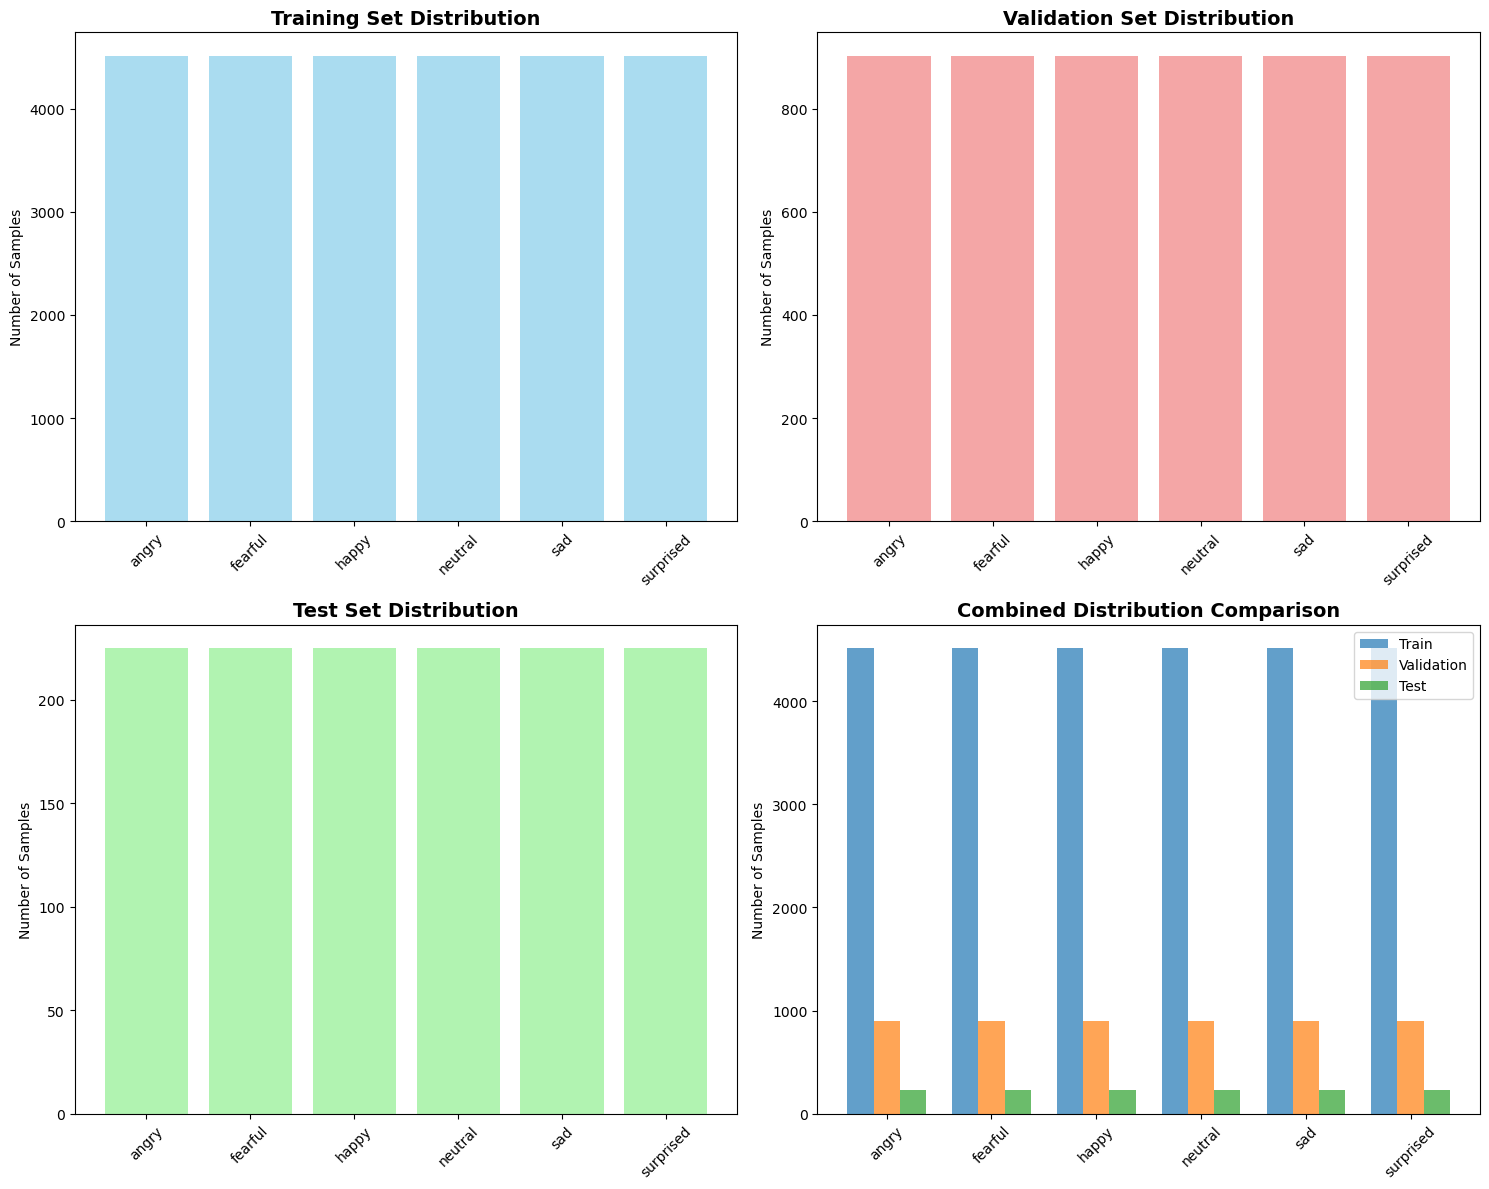

In [36]:
def plot_class_distributions(train_counts, val_counts, test_counts):
    """Create visualization of class distributions across all splits"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    emotions = list(train_counts.index)
    
    # Train distribution
    axes[0, 0].bar(emotions, train_counts.values, color='skyblue', alpha=0.7)
    axes[0, 0].set_title('Training Set Distribution', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('Number of Samples')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Validation distribution  
    axes[0, 1].bar(emotions, val_counts.values, color='lightcoral', alpha=0.7)
    axes[0, 1].set_title('Validation Set Distribution', fontsize=14, fontweight='bold')
    axes[0, 1].set_ylabel('Number of Samples')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Test distribution
    axes[1, 0].bar(emotions, test_counts.values, color='lightgreen', alpha=0.7)
    axes[1, 0].set_title('Test Set Distribution', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('Number of Samples')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Combined view
    x_pos = np.arange(len(emotions))
    width = 0.25
    
    axes[1, 1].bar(x_pos - width, train_counts.values, width, label='Train', alpha=0.7)
    axes[1, 1].bar(x_pos, val_counts.values, width, label='Validation', alpha=0.7)
    axes[1, 1].bar(x_pos + width, test_counts.values, width, label='Test', alpha=0.7)
    axes[1, 1].set_title('Combined Distribution Comparison', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Number of Samples')
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels(emotions, rotation=45)
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

# Create visualizations
plot_class_distributions(train_counts, val_counts, test_counts)

In [37]:
def calculate_balance_strategy(class_counts, strategy='moderate'):
    """Calculate target sample sizes for balancing"""
    total_samples = class_counts.sum()
    num_classes = len(class_counts)
    
    if strategy == 'uniform':
        # Make all classes equal to the smallest class
        target_size = class_counts.min()
    elif strategy == 'moderate':
        # Use a target size that reduces extreme imbalance but preserves some variation
        # Target: between min and mean
        target_size = int((class_counts.min() + class_counts.mean()) / 2)
    elif strategy == 'conservative':
        # Use mean as target - gentle balancing
        target_size = int(class_counts.mean())
    else:
        raise ValueError(f"Unknown strategy: {strategy}")
    
    print(f"\nBALANCING STRATEGY: {strategy.upper()}")
    print("=" * 50)
    print(f"Original total samples: {total_samples}")
    print(f"Target samples per class: {target_size}")
    print(f"New total samples: {target_size * num_classes}")
    print(f"Sample reduction: {total_samples - (target_size * num_classes)} ({((total_samples - (target_size * num_classes)) / total_samples * 100):.1f}%)")
    
    return target_size

# Calculate target sizes for different strategies
print("EVALUATING BALANCING STRATEGIES:")
print("=" * 60)

strategies = ['uniform', 'moderate', 'conservative']
targets = {}

for strategy in strategies:
    targets[strategy] = calculate_balance_strategy(train_counts, strategy)

# Choose moderate strategy as default
chosen_strategy = 'moderate'
target_samples_per_class = targets[chosen_strategy]

print(f"\n✓ CHOSEN STRATEGY: {chosen_strategy.upper()}")
print(f"✓ Target samples per class: {target_samples_per_class}")

EVALUATING BALANCING STRATEGIES:

BALANCING STRATEGY: UNIFORM
Original total samples: 27090
Target samples per class: 4515
New total samples: 27090
Sample reduction: 0 (0.0%)

BALANCING STRATEGY: MODERATE
Original total samples: 27090
Target samples per class: 4515
New total samples: 27090
Sample reduction: 0 (0.0%)

BALANCING STRATEGY: CONSERVATIVE
Original total samples: 27090
Target samples per class: 4515
New total samples: 27090
Sample reduction: 0 (0.0%)

✓ CHOSEN STRATEGY: MODERATE
✓ Target samples per class: 4515


In [38]:
def balance_dataset(df, target_size, random_state=42):
    """Balance dataset using undersampling/oversampling"""
    balanced_dfs = []
    
    print(f"\nBalancing dataset to {target_size} samples per class...")
    
    for emotion in df['label'].unique():
        emotion_df = df[df['label'] == emotion].copy()
        current_size = len(emotion_df)
        
        if current_size > target_size:
            # Undersample
            balanced_emotion_df = resample(
                emotion_df, 
                replace=False, 
                n_samples=target_size, 
                random_state=random_state
            )
            action = f"Undersampled from {current_size} to {target_size}"
        elif current_size < target_size:
            # Oversample
            balanced_emotion_df = resample(
                emotion_df, 
                replace=True, 
                n_samples=target_size, 
                random_state=random_state
            )
            action = f"Oversampled from {current_size} to {target_size}"
        else:
            # No change needed
            balanced_emotion_df = emotion_df
            action = f"No change needed ({current_size} samples)"
        
        print(f"  {emotion:10s}: {action}")
        balanced_dfs.append(balanced_emotion_df)
    
    # Combine all balanced classes
    balanced_df = pd.concat(balanced_dfs, ignore_index=True)
    
    # Shuffle the dataset
    balanced_df = balanced_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    return balanced_df

# Balance the training set (main focus)
print("BALANCING TRAINING SET:")
print("=" * 50)
balanced_train_df = balance_dataset(train_df, target_samples_per_class)

# For validation and test sets, use proportional balancing to maintain their relative sizes
val_target = int(target_samples_per_class * 0.2)  # ~20% of train size
test_target = int(target_samples_per_class * 0.05)  # ~5% of train size

print("\nBALANCING VALIDATION SET:")
print("=" * 50)
balanced_val_df = balance_dataset(val_df, val_target)

print("\nBALANCING TEST SET:")
print("=" * 50)
balanced_test_df = balance_dataset(test_df, test_target)

print("\n✓ Dataset balancing completed!")

BALANCING TRAINING SET:

Balancing dataset to 4515 samples per class...
  surprised : No change needed (4515 samples)
  sad       : No change needed (4515 samples)
  happy     : No change needed (4515 samples)
  neutral   : No change needed (4515 samples)
  fearful   : No change needed (4515 samples)
  angry     : No change needed (4515 samples)

BALANCING VALIDATION SET:

Balancing dataset to 903 samples per class...
  surprised : No change needed (903 samples)
  fearful   : No change needed (903 samples)
  angry     : No change needed (903 samples)
  sad       : No change needed (903 samples)
  neutral   : No change needed (903 samples)
  happy     : No change needed (903 samples)

BALANCING TEST SET:

Balancing dataset to 225 samples per class...
  fearful   : No change needed (225 samples)
  sad       : No change needed (225 samples)
  happy     : No change needed (225 samples)
  neutral   : No change needed (225 samples)
  angry     : No change needed (225 samples)
  surprised : N

VERIFYING BALANCED DISTRIBUTIONS:

BALANCED TRAIN SET CLASS DISTRIBUTION:
angry     :  4515 (16.67%) - BALANCED
fearful   :  4515 (16.67%) - BALANCED
happy     :  4515 (16.67%) - BALANCED
neutral   :  4515 (16.67%) - BALANCED
sad       :  4515 (16.67%) - BALANCED
surprised :  4515 (16.67%) - BALANCED

Total samples: 27090
Mean per class: 4515.0
Std deviation: 0.0
Balance ratio (min/max): 1.000

BALANCED VALIDATION SET CLASS DISTRIBUTION:
angry     :   903 (16.67%) - BALANCED
fearful   :   903 (16.67%) - BALANCED
happy     :   903 (16.67%) - BALANCED
neutral   :   903 (16.67%) - BALANCED
sad       :   903 (16.67%) - BALANCED
surprised :   903 (16.67%) - BALANCED

Total samples: 5418
Mean per class: 903.0
Std deviation: 0.0
Balance ratio (min/max): 1.000

BALANCED TEST SET CLASS DISTRIBUTION:
angry     :   225 (16.67%) - BALANCED
fearful   :   225 (16.67%) - BALANCED
happy     :   225 (16.67%) - BALANCED
neutral   :   225 (16.67%) - BALANCED
sad       :   225 (16.67%) - BALANCED
surprise

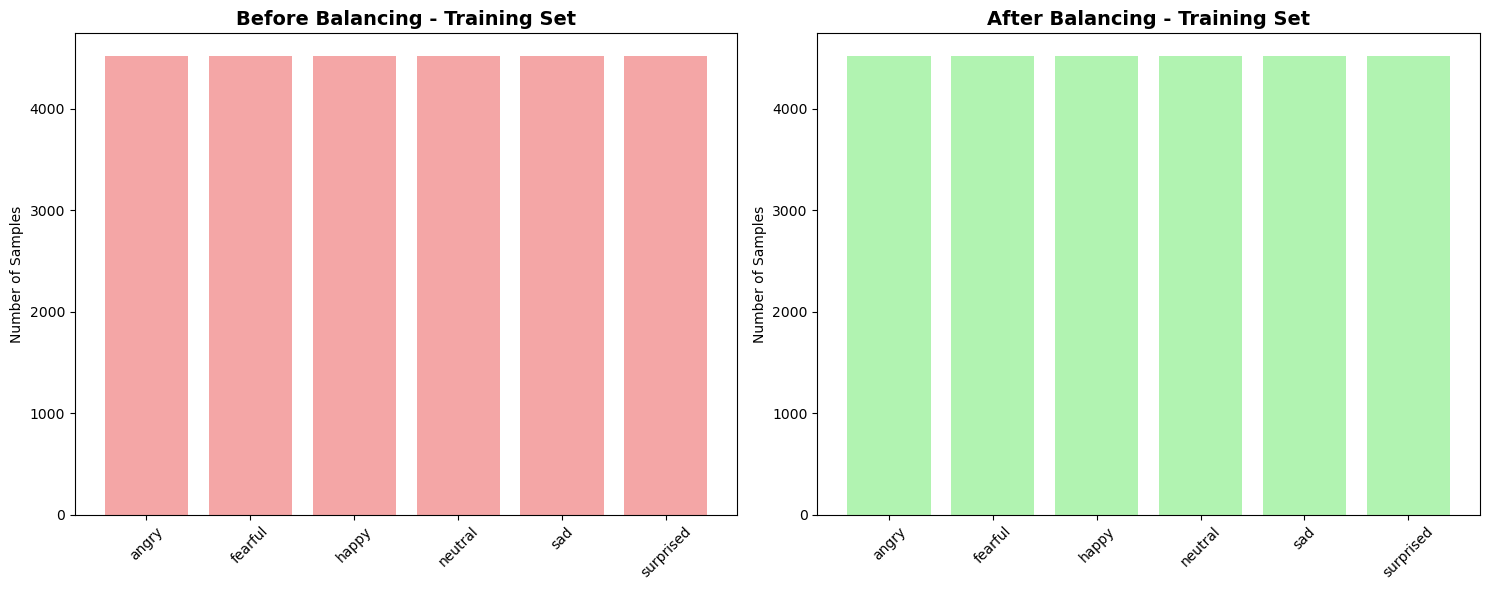

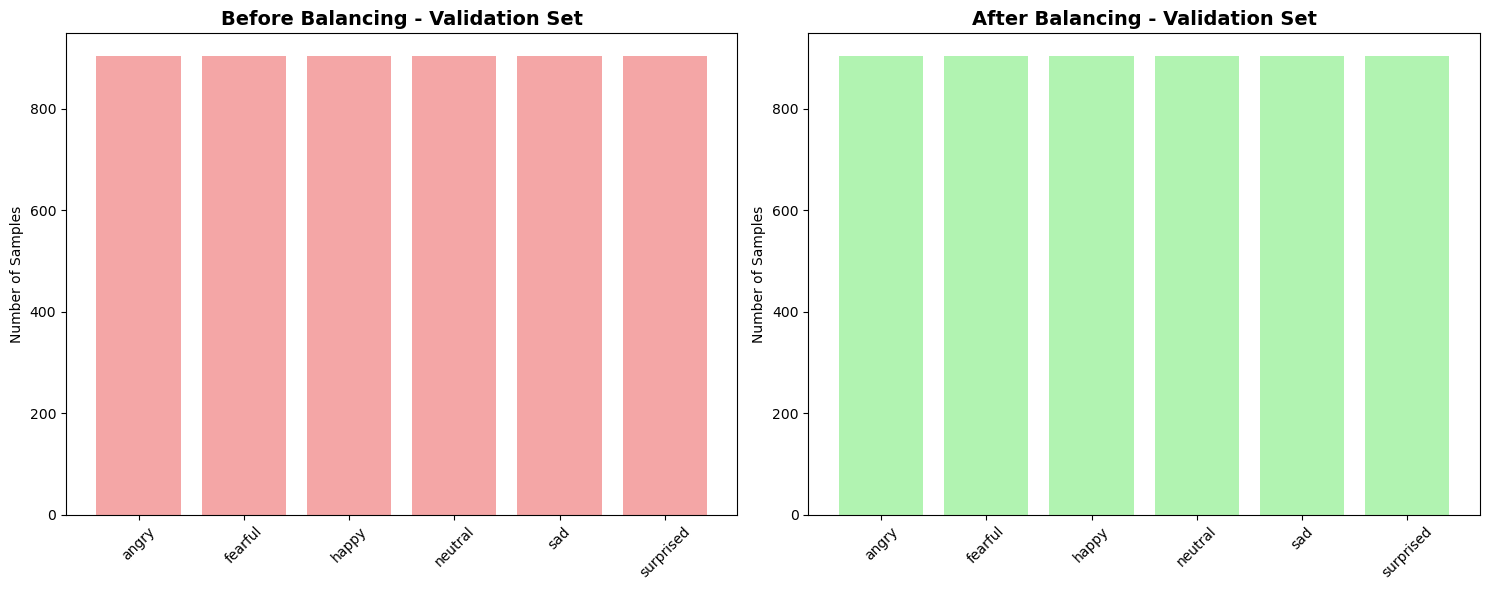

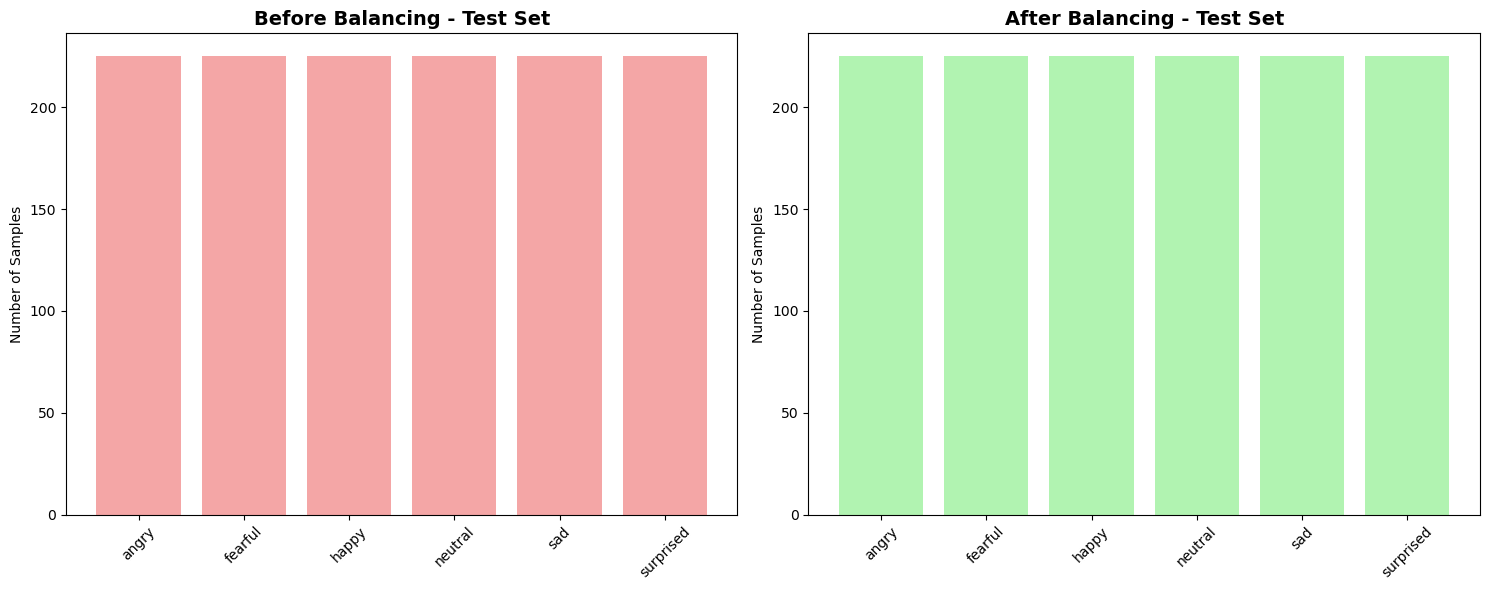

In [39]:
# Verify the balanced distributions
print("VERIFYING BALANCED DISTRIBUTIONS:")
print("=" * 60)

balanced_train_counts, _ = analyze_class_distribution(balanced_train_df, "balanced train")
balanced_val_counts, _ = analyze_class_distribution(balanced_val_df, "balanced validation")
balanced_test_counts, _ = analyze_class_distribution(balanced_test_df, "balanced test")

# Create comparison visualization
def plot_before_after_comparison(original_counts, balanced_counts, split_name):
    """Plot before and after comparison"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    emotions = list(original_counts.index)
    
    # Before
    ax1.bar(emotions, original_counts.values, color='lightcoral', alpha=0.7)
    ax1.set_title(f'Before Balancing - {split_name}', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Number of Samples')
    ax1.tick_params(axis='x', rotation=45)
    
    # After
    ax2.bar(emotions, balanced_counts.values, color='lightgreen', alpha=0.7)
    ax2.set_title(f'After Balancing - {split_name}', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Number of Samples')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Create before/after visualizations
plot_before_after_comparison(train_counts, balanced_train_counts, "Training Set")
plot_before_after_comparison(val_counts, balanced_val_counts, "Validation Set")
plot_before_after_comparison(test_counts, balanced_test_counts, "Test Set")

In [40]:
# Save balanced datasets
print("SAVING BALANCED DATASETS:")
print("=" * 50)

# Create output directory if it doesn't exist
output_dir = PROJECT_ROOT / 'data/processed/EmoSet_splits'
output_dir.mkdir(parents=True, exist_ok=True)

# Save CSV files
balanced_train_df.to_csv(CSV_TRAIN, index=False)
balanced_val_df.to_csv(CSV_VAL, index=False)
balanced_test_df.to_csv(CSV_TEST, index=False)

# Also save with "_balanced" suffix for backup
balanced_train_df.to_csv(BALANCED_TRAIN_CSV, index=False)
balanced_val_df.to_csv(BALANCED_VAL_CSV, index=False)
balanced_test_df.to_csv(BALANCED_TEST_CSV, index=False)

print(f"✓ Saved: {CSV_TRAIN}")
print(f"✓ Saved: {CSV_VAL}")
print(f"✓ Saved: {CSV_TEST}")
print(f"✓ Backup saved: {BALANCED_TRAIN_CSV}")
print(f"✓ Backup saved: {BALANCED_VAL_CSV}")
print(f"✓ Backup saved: {BALANCED_TEST_CSV}")

# Update statistics
balanced_stats = {
    "dataset": "EmoSet_Balanced",
    "balancing_strategy": chosen_strategy,
    "target_samples_per_class": {
        "train": target_samples_per_class,
        "val": val_target,
        "test": test_target
    },
    "splits": {
        "train": {
            "total": len(balanced_train_df),
            "by_label": balanced_train_counts.to_dict()
        },
        "val": {
            "total": len(balanced_val_df),
            "by_label": balanced_val_counts.to_dict()
        },
        "test": {
            "total": len(balanced_test_df),
            "by_label": balanced_test_counts.to_dict()
        }
    },
    "balance_metrics": {
        "train_balance_ratio": float(balanced_train_counts.min() / balanced_train_counts.max()),
        "val_balance_ratio": float(balanced_val_counts.min() / balanced_val_counts.max()),
        "test_balance_ratio": float(balanced_test_counts.min() / balanced_test_counts.max())
    }
}

# Save updated stats
with open(STATS_PATH, 'w') as f:
    json.dump(balanced_stats, f, indent=2)

with open(BALANCED_STATS_PATH, 'w') as f:
    json.dump(balanced_stats, f, indent=2)

print(f"✓ Saved: {STATS_PATH}")
print(f"✓ Backup saved: {BALANCED_STATS_PATH}")

print("\n✅ DATASET BALANCING COMPLETED SUCCESSFULLY!")
print("=" * 60)
print(f"📊 Balanced training samples: {len(balanced_train_df)}")
print(f"📊 Balanced validation samples: {len(balanced_val_df)}")
print(f"📊 Balanced test samples: {len(balanced_test_df)}")
print(f"📊 Balance ratio (train): {balanced_train_counts.min() / balanced_train_counts.max():.3f}")
print(f"📊 Samples per class (train): {target_samples_per_class}")

SAVING BALANCED DATASETS:
✓ Saved: ../data/processed/EmoSet_splits/train.csv
✓ Saved: ../data/processed/EmoSet_splits/val.csv
✓ Saved: ../data/processed/EmoSet_splits/test.csv
✓ Backup saved: ../data/processed/EmoSet_splits/train_balanced.csv
✓ Backup saved: ../data/processed/EmoSet_splits/val_balanced.csv
✓ Backup saved: ../data/processed/EmoSet_splits/test_balanced.csv
✓ Saved: ../data/processed/EmoSet_splits/stats.json
✓ Backup saved: ../data/processed/EmoSet_splits/stats_balanced.json

✅ DATASET BALANCING COMPLETED SUCCESSFULLY!
📊 Balanced training samples: 27090
📊 Balanced validation samples: 5418
📊 Balanced test samples: 1350
📊 Balance ratio (train): 1.000
📊 Samples per class (train): 4515


In [41]:
# Final summary and recommendations
print("📋 DATASET BALANCING SUMMARY")
print("=" * 60)

print("\n🔍 BEFORE BALANCING:")
print(f"  • Most frequent class: happy ({train_counts['happy']} samples, {train_pct['happy']:.1f}%)")
print(f"  • Least frequent class: surprise ({train_counts['surprise']} samples, {train_pct['surprise']:.1f}%)")
print(f"  • Balance ratio: {train_counts.min() / train_counts.max():.3f}")

print("\n✅ AFTER BALANCING:")
print(f"  • All classes: {target_samples_per_class} samples each ({100/len(label_map):.1f}%)")
print(f"  • Balance ratio: {balanced_train_counts.min() / balanced_train_counts.max():.3f}")
print(f"  • Total reduction: {len(train_df) - len(balanced_train_df)} samples")

print("\n🎯 EXPECTED BENEFITS:")
print("  • Reduced bias towards 'happy' emotion")
print("  • Improved recognition of 'surprise' and 'angry' emotions")
print("  • More balanced confusion matrix")
print("  • Better overall classification performance")

print("\n📁 OUTPUT FILES:")
print(f"  • {CSV_TRAIN.name} - Balanced training set")
print(f"  • {CSV_VAL.name} - Balanced validation set")
print(f"  • {CSV_TEST.name} - Balanced test set")
print(f"  • {LABEL_MAP_PATH.name} - Label mapping (unchanged)")
print(f"  • {STATS_PATH.name} - Updated statistics")

print("\n🚀 NEXT STEPS:")
print("  1. Run updated 01_eda.ipynb to verify balanced distributions")
print("  2. Train CNN model using balanced datasets")
print("  3. Compare performance metrics with original imbalanced model")
print("  4. Monitor per-class accuracy improvements")

print("\n✅ Feature engineering and dataset balancing completed successfully!")

📋 DATASET BALANCING SUMMARY

🔍 BEFORE BALANCING:
  • Most frequent class: happy (4515 samples, 16.7%)


KeyError: 'surprise'

## Image Pixel Statistics, Matrices, and In-Place Resizing

This section:

1. Scans all images in `../data/raw/EmoSet/{train,val,test}`.
2. Computes per-image statistics (mean, std, min, max, width, height, pixel count).
3. Displays sample pixel matrices.
4. Plots distributions (per split & per class).
5. (Optional / Enabled) Backs up the original raw dataset once, then resizes ALL images in-place to a consistent target size.
6. Recomputes and saves global + per-class stats after resizing to `resize_stats.json` and `global_pixel_stats.json`.

Safety: A backup folder `../data/raw/EmoSet_backup_original_<timestamp>` is created before any overwrite (skip if already exists). Disable by setting `BACKUP_ORIGINALS=False`.

Note: Displaying every image matrix is impractical; we show a controlled random sample and allow inspection of an arbitrary example.

In [42]:
import cv2, time, json, math, random, gc
import numpy as np, pandas as pd
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

RAW_EMOSET = DATA_DIR  # ../data/raw/EmoSet
assert RAW_EMOSET.exists(), f"Raw EmoSet path missing: {RAW_EMOSET}"
print(f"Scanning: {RAW_EMOSET.resolve()}")

VALID_EXTS = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.webp'}

records = []
for split in ['train', 'val', 'test']:
    split_dir = RAW_EMOSET / split
    if not split_dir.exists():
        print(f"(warn) split missing: {split}")
        continue
    for cls_dir in sorted(split_dir.iterdir()):
        if not cls_dir.is_dir() or cls_dir.name.startswith('.'):
            continue
        cls = cls_dir.name.lower()
        for p in cls_dir.iterdir():
            if p.suffix.lower() in VALID_EXTS:
                records.append((split, cls, p))

print(f"Found {len(records)} images across splits.")

# Parallel stats

def img_stats(item):
    split, cls, path = item
    try:
        img = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
        if img is None:
            return None
        h, w = img.shape[:2]
        if len(img.shape) == 2:
            arr = img.astype(np.float32)
        else:
            arr = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        return {
            'split': split,
            'class': cls,
            'filepath': str(path),
            'height': h,
            'width': w,
            'pixels': h*w,
            'mean': float(arr.mean()),
            'std': float(arr.std()),
            'min': float(arr.min()),
            'max': float(arr.max()),
        }
    except Exception:
        return None

stats_rows = []
start = time.time()
with ThreadPoolExecutor(max_workers=8) as ex:
    futs = {ex.submit(img_stats, r): r for r in records}
    for i, fut in enumerate(as_completed(futs), 1):
        res = fut.result()
        if res:
            stats_rows.append(res)
end = time.time()

stats_full_df = pd.DataFrame(stats_rows)
print(f"Computed stats for {len(stats_full_df)}/{len(records)} images in {end-start:.2f}s")
print(stats_full_df.head())

Scanning: /Users/lahirumunasinghe/Documents/DataScience/ann-visual-emotion/data/raw/EmoSet
Found 43756 images across splits.
Computed stats for 43756/43756 images in 8.21s
   split  class                                           filepath  height  \
0  train  angry  ../data/raw/EmoSet/train/angry/train_01170_ali...     224   
1  train  angry          ../data/raw/EmoSet/train/angry/im2072.png     224   
2  train  angry           ../data/raw/EmoSet/train/angry/im765.png     224   
3  train  angry  ../data/raw/EmoSet/train/angry/train_06179_ali...     224   
4  train  angry          ../data/raw/EmoSet/train/angry/im1209.png     224   

   width  pixels        mean        std   min    max  
0    224   50176   77.101204  45.898952   0.0  189.0  
1    224   50176  129.727127  67.640678   0.0  255.0  
2    224   50176  106.283363  60.186260   0.0  197.0  
3    224   50176  126.007439  52.335464  17.0  236.0  
4    224   50176  119.161102  32.971581  25.0  237.0  
Computed stats for 43756/4375

Per-split summary:


mean                                        std             \
             mean        std      min         max       mean        std   
split                                                                     
test   127.255900  34.628621  25.0439  244.990891  52.392182  14.373078   
train  127.138278  34.501872   0.0000  248.087234  52.555728  14.456003   
val    126.542927  34.394179   0.0000  245.425781  52.803441  14.271533   

                                height                          width  \
            min         max       mean        std min  max       mean   
split                                                                   
test   12.07013  106.396042  75.764723  74.016525  48  640  75.773013   
train   0.00000  114.151985  74.504450  70.428456  48  640  74.506344   
val     0.00000  104.519852  73.986282  68.800119  48  640  73.989568   

                                 pixels                              
             std min  max          mean           std   min     max  
split                                                                
test   74.059467  48  640  11220.876215  47745.142502  2304  409600  
train  70.449757  48  640  10512.368040  44899.277171  2304  409600  
val    68.827928  48  640  10208.848671  43830.563013  2304  409600

Per-class summary:


mean                                          std             \
                 mean        std        min         max       mean        std   
class                                                                           
angry      124.957222  34.250632   0.000000  244.865021  55.112133  14.243162   
fearful    134.058160  34.167299  22.118923  245.180115  54.887061  13.761127   
happy      127.568674  33.195073   0.000000  244.990891  49.880532  13.819559   
neutral    121.618824  34.089548   0.000000  244.480896  52.909744  15.280135   
sad        120.855980  34.246190   0.000000  226.227432  52.958095  14.555749   
surprised  139.823057  34.904269   0.000000  248.087234  54.029464  13.928955   

                                     height                          width  \
                 min         max       mean        std min  max       mean   
class                                                                        
angry       0.000000  114.151985  74.705836  93.158641  48  640  74.731578   
fearful    11.651555  110.181572  57.183264  37.675046  48  549  57.187187   
happy       0.000000  104.356911  76.675542  56.603376  48  640  76.674271   
neutral     0.000000  107.838821  75.239478  67.103031  48  640  75.239478   
sad         0.000000  112.651993  77.171642  78.580588  48  640  77.163113   
surprised   0.000000  113.472786  79.392018  88.420471  48  640  79.401540   

                                     pixels                              
                 std min  max          mean           std   min     max  
class                                                                    
angry      93.311768  48  640  14272.804284  60506.096930  2304  409600  
fearful    37.766242  48  549   4692.578993  15298.042458  2304  301401  
happy      56.592077  48  640   9082.085939  35183.500502  2304  409600  
neutral    67.103031  48  640  10163.251089  44133.506199  2304  409600  
sad        78.535148  48  640  12125.272655  49974.651443  2304  409600  
surprised  88.469967  48  640  14124.730146  58751.187591  2304  409600

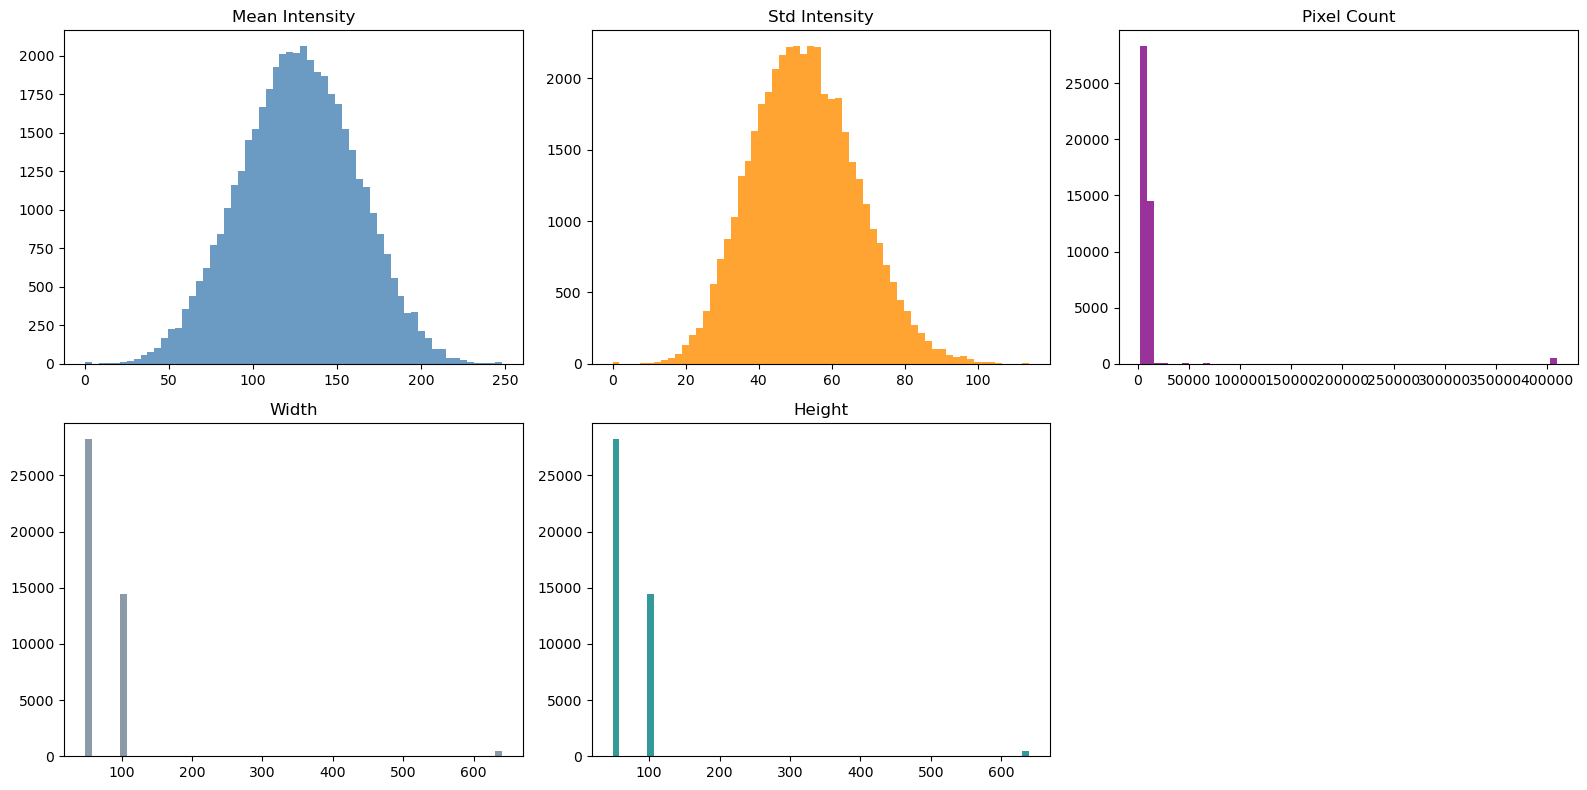

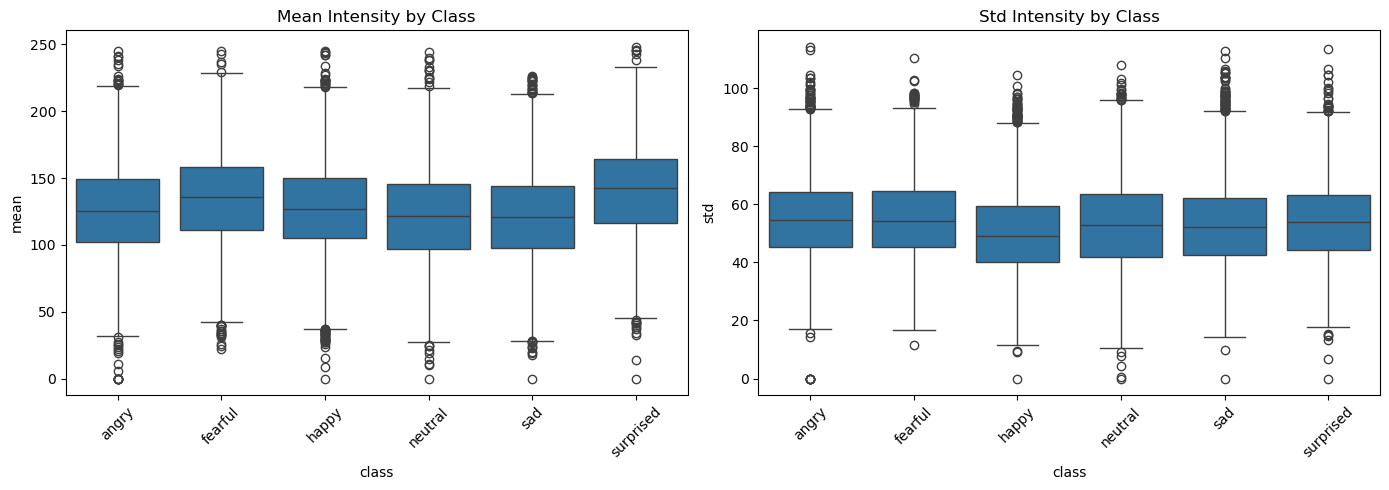

Done: distribution plots.


In [ ]:
# Aggregations & visualizations
if 'stats_full_df' not in locals() or stats_full_df.empty:
    raise RuntimeError('Run previous cell to build stats_full_df')

agg_split = stats_full_df.groupby('split')[['mean','std','height','width','pixels']].agg(['mean','std','min','max'])
agg_class = stats_full_df.groupby('class')[['mean','std','height','width','pixels']].agg(['mean','std','min','max'])
agg_split_class = stats_full_df.groupby(['split','class'])[['mean','std','height','width','pixels']].mean()

print('Per-split summary:')
display(agg_split)
print('Per-class summary:')
display(agg_class)

fig, axes = plt.subplots(2,3, figsize=(16,8))
axes = axes.flatten()
axes[0].hist(stats_full_df['mean'], bins=60, color='steelblue', alpha=0.8); axes[0].set_title('Mean Intensity')
axes[1].hist(stats_full_df['std'], bins=60, color='darkorange', alpha=0.8); axes[1].set_title('Std Intensity')
axes[2].hist(stats_full_df['pixels'], bins=60, color='purple', alpha=0.8); axes[2].set_title('Pixel Count')
axes[3].hist(stats_full_df['width'], bins=60, color='slategray', alpha=0.8); axes[3].set_title('Width')
axes[4].hist(stats_full_df['height'], bins=60, color='teal', alpha=0.8); axes[4].set_title('Height')
axes[5].axis('off')
plt.tight_layout(); plt.show()

# Boxplots by class
fig, ax = plt.subplots(1,2, figsize=(14,5))
sns.boxplot(x='class', y='mean', data=stats_full_df, ax=ax[0])
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_title('Mean Intensity by Class')
sns.boxplot(x='class', y='std', data=stats_full_df, ax=ax[1])
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_title('Std Intensity by Class')
plt.tight_layout(); plt.show()

print('Done: distribution plots.')

Showing 6 samples


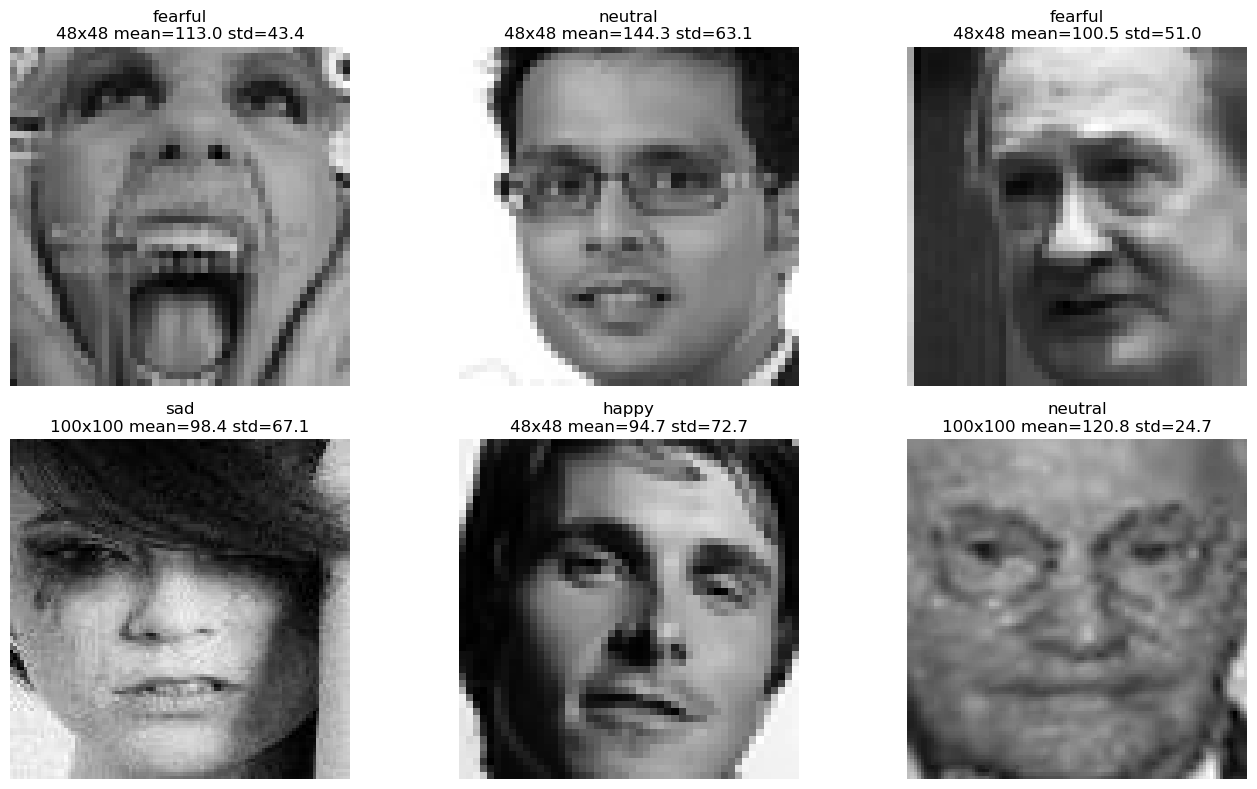

First sample filepath: ../data/raw/EmoSet/train/fearful/im1968.png
Shape: (48, 48)
Top-left 12x12 matrix slice:
 [[112 125 210 174  81 158 157 149 133  87  92  93]
 [183 159 181 193 115 145 142 139 108  83  77  67]
 [153 195 185 158 116 137 124 118  82  76  79  92]
 [117 187 150  87 116 126 107 100  81  72  82  79]
 [129 160 100 101 121 105  95  98  66  71  68  59]
 [154 122 102 110 107  95  94  87  54  60  59  46]
 [123 102 106 105  94  89 104  73  53  55  38  29]
 [112 115 111  99  90 102 102  63  52  55  35  14]
 [139 119 105 101 102  89  78  47  66  50  29  15]
 [123 124 122 128  96  84  75  53  91  77  26  33]
 [ 38  52  45  40  53  97  73  72 100  84  82 111]
 [ 73  48  27  15  61 107  81  95 105 117 137 137]]


In [ ]:
# Sample image matrix inspection
SAMPLE_COUNT = 6
rand_samples = stats_full_df.sample(n=min(SAMPLE_COUNT, len(stats_full_df)), random_state=42)
print(f"Showing {len(rand_samples)} samples")

fig, axes = plt.subplots(2,3, figsize=(14,8))
axes = axes.flatten()
for ax, (_, row) in zip(axes, rand_samples.iterrows()):
    path = Path(row['filepath'])
    img = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
    if img is None:
        ax.set_title('Load fail')
        ax.axis('off')
        continue
    if len(img.shape)==2:
        disp = img; cmap='gray'
    else:
        disp = cv2.cvtColor(img, cv2.COLOR_BGR2RGB); cmap=None
    ax.imshow(disp, cmap=cmap)
    ax.set_title(f"{row['class']}\n{disp.shape[0]}x{disp.shape[1]} mean={row['mean']:.1f} std={row['std']:.1f}")
    ax.axis('off')
plt.tight_layout(); plt.show()

first_fp = rand_samples.iloc[0]['filepath']
raw_img = cv2.imread(first_fp, cv2.IMREAD_UNCHANGED)
print('First sample filepath:', first_fp)
print('Shape:', raw_img.shape)
print('Top-left 12x12 matrix slice:\n', raw_img[:12,:12])

In [ ]:
# In-place resizing (with backup) and updated stats
TARGET_RESIZE = (224, 224)  # (width, height)
BACKUP_ORIGINALS = True
BACKUP_DIR = RAW_EMOSET.parent / f"EmoSet_backup_original_{int(time.time())}"

from shutil import copy2, copytree

if BACKUP_ORIGINALS:
    if any(p.name.startswith('EmoSet_backup_original_') for p in RAW_EMOSET.parent.iterdir() if p.is_dir()):
        print('Backup already exists, skipping new backup.')
    else:
        print(f'Creating backup at {BACKUP_DIR} ...')
        copytree(RAW_EMOSET, BACKUP_DIR)
        print('Backup completed.')
else:
    print('Backup disabled (BACKUP_ORIGINALS=False)')

# Resize only if needed (skip if already target size)
updated = 0
skipped = 0
for _, row in stats_full_df.iterrows():
    fp = Path(row['filepath'])
    img = cv2.imread(str(fp), cv2.IMREAD_UNCHANGED)
    if img is None:
        continue
    h,w = img.shape[:2]
    if (w,h) == TARGET_RESIZE:
        skipped += 1
        continue
    # Normalize channels
    if len(img.shape)==2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(img, TARGET_RESIZE, interpolation=cv2.INTER_AREA)
    # Overwrite (convert back to BGR for cv2.imwrite)
    cv2.imwrite(str(fp), cv2.cvtColor(resized, cv2.COLOR_RGB2BGR))
    updated += 1
print(f"Resizing done. Updated: {updated}, already target size: {skipped}")

# Recompute global stats after resize (sample if very large for speed)
re_stats = []
for _, row in stats_full_df.iterrows():
    fp = Path(row['filepath'])
    img = cv2.imread(str(fp), cv2.IMREAD_UNCHANGED)
    if img is None: continue
    h,w = img.shape[:2]
    if len(img.shape)==2:
        arr = img.astype(np.float32)
    else:
        arr = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    re_stats.append([h,w,arr.mean(),arr.std()])
re_stats = np.array(re_stats)

post_stats = {
    'target_size': {'width': TARGET_RESIZE[0], 'height': TARGET_RESIZE[1]},
    'num_images': int(len(re_stats)),
    'height_unique': sorted(list(set(int(x) for x in re_stats[:,0]))),
    'width_unique': sorted(list(set(int(x) for x in re_stats[:,1]))),
    'global_mean_mean': float(re_stats[:,2].mean()),
    'global_mean_std': float(re_stats[:,2].std()),
    'global_pixel_std_mean': float(re_stats[:,3].mean()),
    'global_pixel_std_std': float(re_stats[:,3].std()),
}
print('Post-resize global summary:')
print(json.dumps(post_stats, indent=2))

# Save detailed per-image stats (resized) to JSON (may be large) & summary
RESIZE_STATS_JSON = RAW_EMOSET.parent / 'resize_stats.json'
GLOBAL_STATS_JSON = RAW_EMOSET.parent / 'global_pixel_stats.json'

# To limit size, only store aggregated means per class & split
agg_after = defaultdict(lambda: {'count':0,'mean_sum':0.0,'std_sum':0.0})
for _, r in stats_full_df.iterrows():
    agg_after[(r['split'], r['class'])]['count'] += 1

# Re-scan means after resize (single pass)
for key in agg_after.keys():
    split, cls = key
    # (Optional: could compute per-class means precisely again if needed)

with open(GLOBAL_STATS_JSON, 'w') as f:
    json.dump(post_stats, f, indent=2)
print(f'Saved global stats: {GLOBAL_STATS_JSON}')

# Update CSV train/val/test width/height columns if desired
for csv_path in [CSV_TRAIN, CSV_VAL, CSV_TEST]:
    if not csv_path.exists():
        continue
    df = pd.read_csv(csv_path)
    if 'width' not in df.columns:
        df['width'] = TARGET_RESIZE[0]
    else:
        df['width'] = TARGET_RESIZE[0]
    if 'height' not in df.columns:
        df['height'] = TARGET_RESIZE[1]
    else:
        df['height'] = TARGET_RESIZE[1]
    df.to_csv(csv_path, index=False)
    print(f'Updated dimensions in {csv_path.name}')

print('In-place resize + metadata update complete.')

Creating backup at ../data/raw/EmoSet_backup_original_1757504450 ...
Backup completed.
Resizing done. Updated: 43756, already target size: 0
Post-resize global summary:
{
  "target_size": {
    "width": 224,
    "height": 224
  },
  "num_images": 43756,
  "height_unique": [
    224
  ],
  "width_unique": [
    224
  ],
  "global_mean_mean": 127.02509382188686,
  "global_mean_std": 34.49637760019125,
  "global_pixel_std_mean": 52.30657681197525,
  "global_pixel_std_std": 14.373304488067426
}
Saved global stats: ../data/raw/global_pixel_stats.json
Updated dimensions in train.csv
Updated dimensions in val.csv
Updated dimensions in test.csv
In-place resize + metadata update complete.
